In [2]:
# jupyter-notebook V0_1_1.ipynb --port 8888 --ip 192.168.1.5

import cv2
import numpy as np
from matplotlib import pyplot as plt
import itertools  
import time
import numba as nb
import copy
from components_container import ComponentsContainerWithHistory
import logging
logging.basicConfig(level=logging.INFO)

%matplotlib inline

In [11]:
displayed_sq = 1500
width_margin = 0
height_margin = 0
def show_img(img):
    fig = plt.figure(figsize=(13, 13), dpi= 80, facecolor='w', edgecolor='k')
    plt.imshow(img[height_margin:height_margin+displayed_sq,width_margin:width_margin+displayed_sq], cmap="ocean")

In [12]:
img = cv2.imread('../raw_pics/t.bmp')


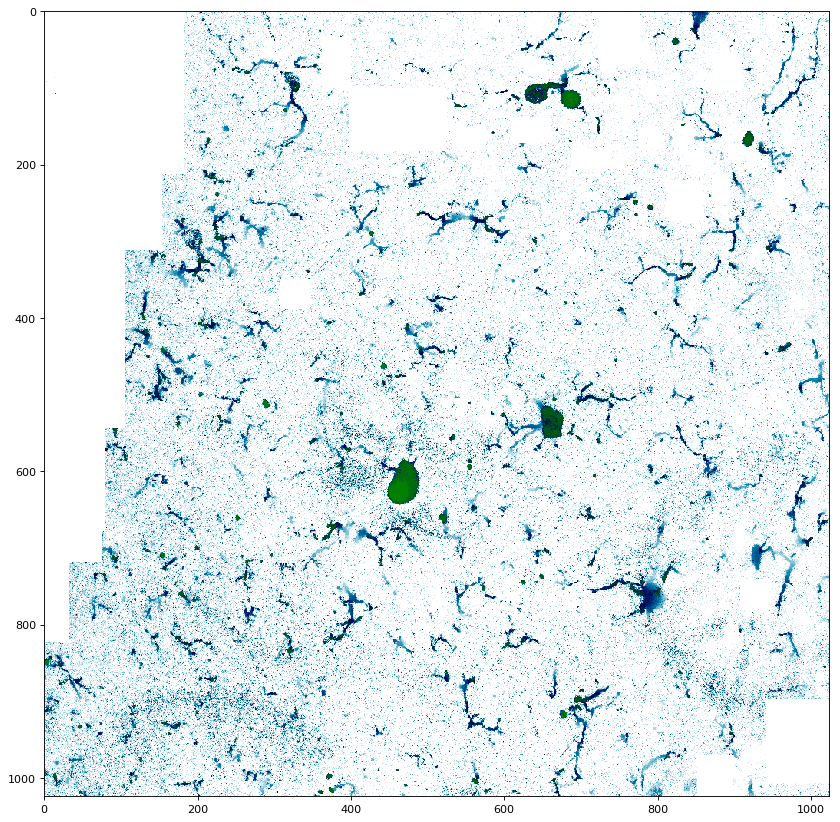

In [26]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
invert = cv2.bitwise_not(gray)
show_img(invert)

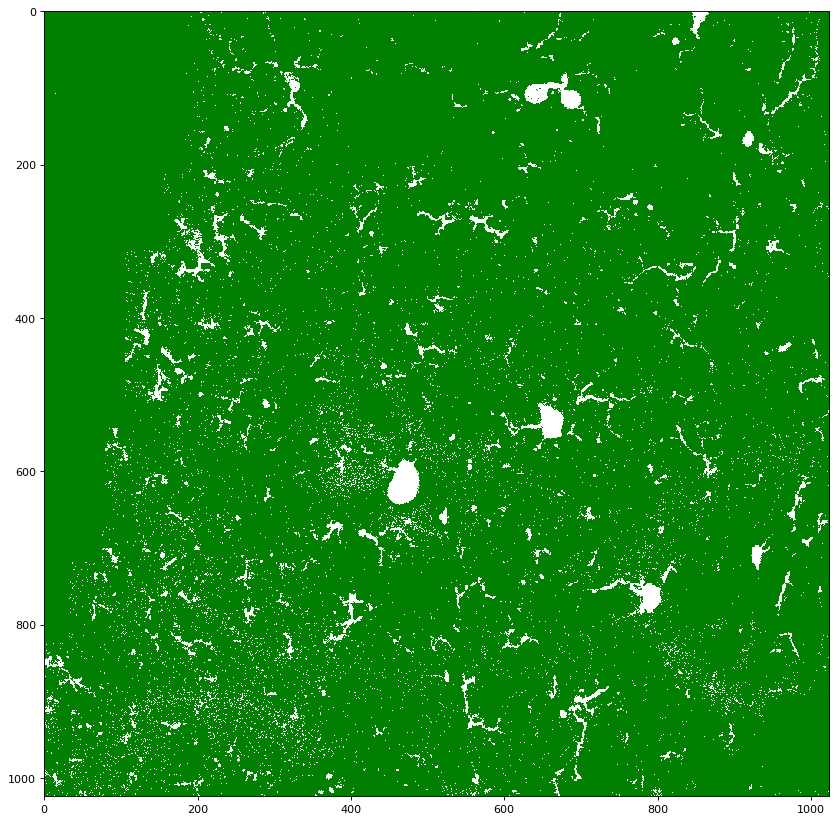

In [34]:
BACKGROUND_INTENSITY_THRESHOLD = 20

ret, binary = cv2.threshold(gray, BACKGROUND_INTENSITY_THRESHOLD, 400, cv2.THRESH_BINARY)
show_img(binary)

INFO:ComponentsContainerWithHistory:size prefiltering (separating big ones) took 0.03744196891784668 sec
INFO:ComponentsContainerWithHistory:size prefiltering (deleting small ones) took 0.2804419994354248 sec
INFO:ComponentsContainerWithHistory:adding edge info to components took 1.6418869495391846 sec


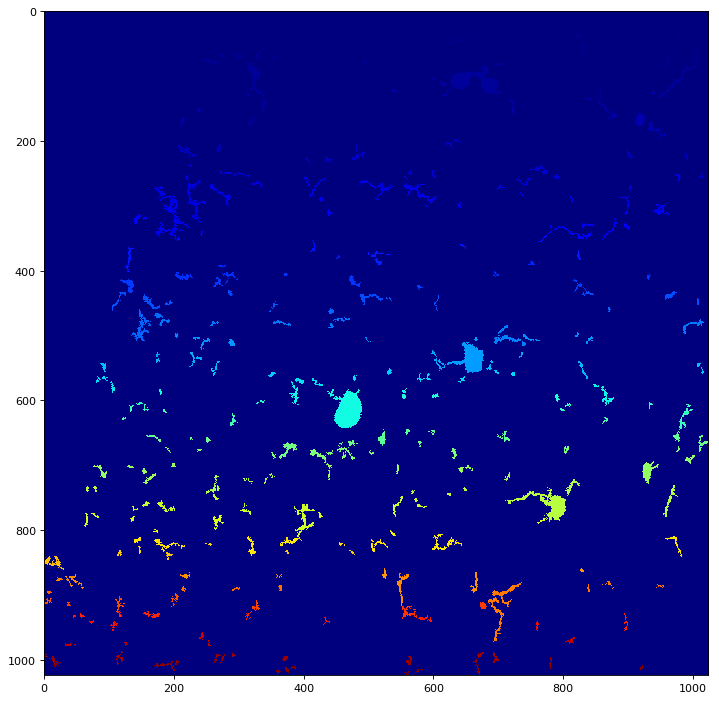

In [35]:
# filter all noise using minimum size threshold

MIN_AXON_SIZE = 20
container = ComponentsContainerWithHistory(binary, MIN_AXON_SIZE, logging.INFO)
container.show_components()

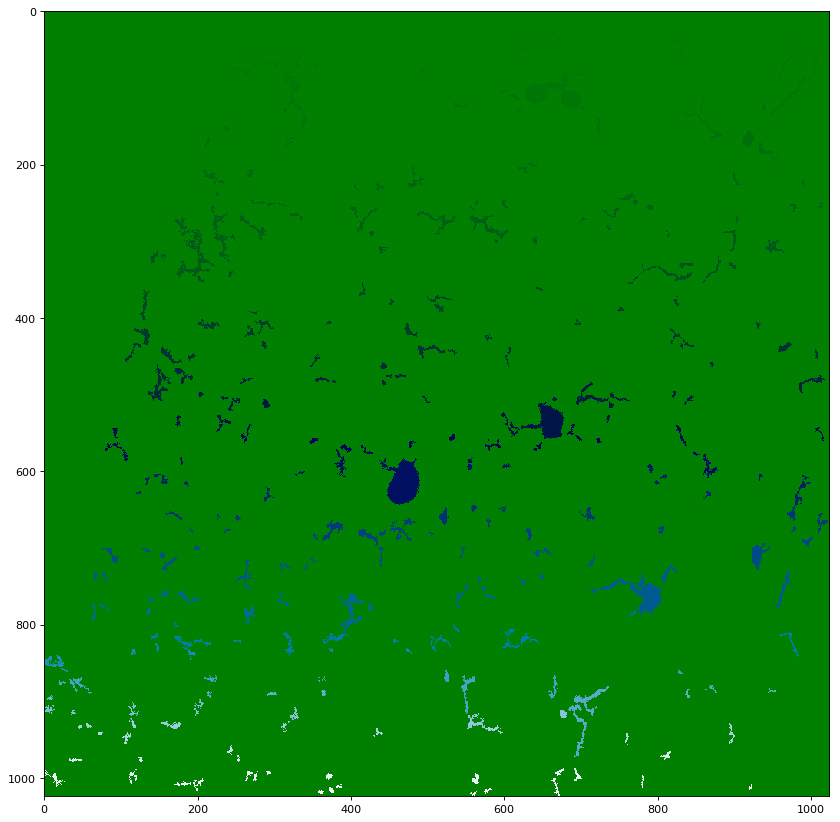

In [36]:
show_img(container.markers)

INFO:ComponentsContainerWithHistory:discarding previous components merge and axon-nucleus spliting
INFO:ComponentsContainerWithHistory:selecting all pairs to merge took 0.6198136806488037 sec
INFO:ComponentsContainerWithHistory:merging took 0.16823291778564453 sec


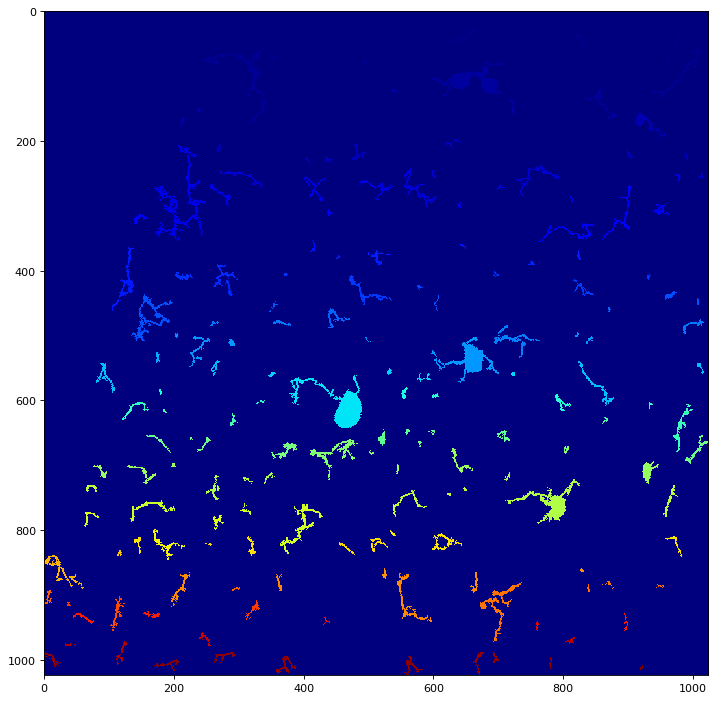

In [37]:
# merging close components based on centroids and contour distance

# for correct work please recompile from here if any of following paramethers changed

PREMERGE_CENTROIDS_DISTANCE_T  = 200
PREMERGE_CONTOUR_DISTANCE_T = 15

container.merge_components_closer_than(PREMERGE_CENTROIDS_DISTANCE_T, PREMERGE_CONTOUR_DISTANCE_T)
container.show_components()

INFO:ComponentsContainerWithHistory:discarding previous axon-nucleus spliting
INFO:ComponentsContainerWithHistory:splitting completted in 0.0006070137023925781, 
axons: 125, nucl: 50


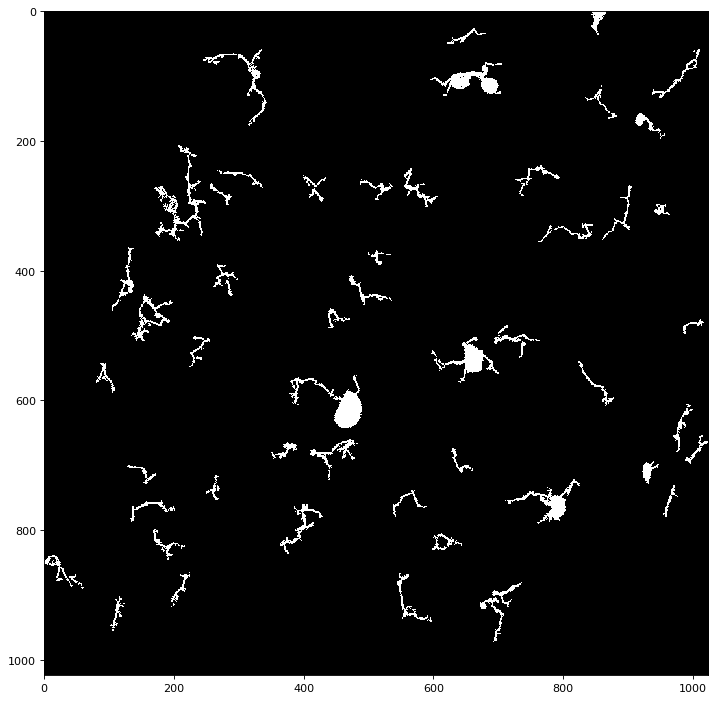

In [38]:
#splitting nucleus and axons based on size

MIN_NUCLEUS_SIZE = 150

container.split_nucl_axon(MIN_NUCLEUS_SIZE)
container.add_hull_info_to_nucleus()
container.show_nucl_and_axons()

INFO:ComponentsContainerWithHistory:discarding previous axon to nucleus grouping
INFO:ComponentsContainerWithHistory:grouping ax to nucl took 0.12456393241882324 sec
 axons with nucleus: 30


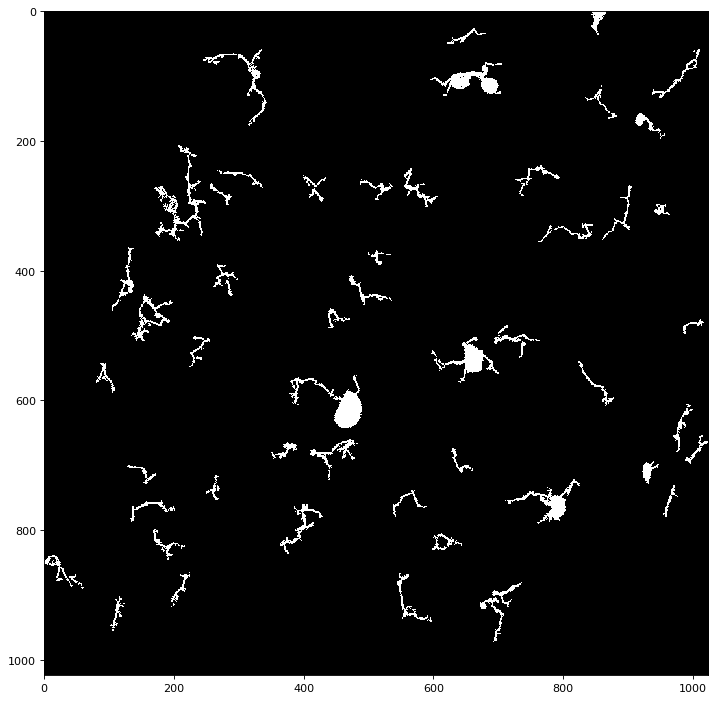

In [39]:
#grouping possible axons to nucleus

CENTROIDS_DISTANCE_T = 90
CONTOUR_DISTANCE_T = 25

container.group_axons_to_nucleus(CENTROIDS_DISTANCE_T, CONTOUR_DISTANCE_T)
container.show_nucl_and_axons()

In [40]:
def draw_nucleus_from_container(container):
    labs = sorted(container.nucleus_labs, key = lambda x: -container.components_index.get(x).size)

    pic = np.zeros(container.markers.shape)
    nucl_color = 400
    axon_color = 409
    color_switch = 1
    switch_val = 40
    for nucl_lab in labs:
        pic[container.markers == nucl_lab] = np.sqrt(container.components_index.get(nucl_lab).size)
        for ax in container.components_index.get(nucl_lab).axons:
            pic[container.markers == ax.label] = np.sqrt(container.components_index.get(nucl_lab).size)

        nucl_color += color_switch * switch_val 
        axon_color += color_switch * switch_val
        color_switch *= 1

    
        
    fig = plt.figure(figsize=(11, 11), dpi=80, facecolor='w', edgecolor='k')
    
    plt.imshow(pic[height_margin:height_margin + displayed_sq, width_margin:width_margin + displayed_sq],
                   cmap="jet")
  

def enhance_img_with_container(img, container):
    edge_color = [80,0,80]
    hull_color = [0,0,100]
    for nucl_lab in container.nucleus_labs:           
        hull = np.array(container.components_index.get(nucl_lab).hull, np.int32)
        hull.reshape((-1,1,2))
        hull = hull[:,::-1]
        cv2.polylines(img, [hull],True, hull_color)

        for ed in container.components_index.get(nucl_lab).edge:
            img[ed[0], ed[1]] = edge_color
    return img

container.add_hull_info_to_nucleus()
invert_3 = np.stack((invert,invert,invert), axis=-1)
#draw_nucleus_from_container(container)
cv2.imwrite('../test_o.png',invert_3)

pic = enhance_img_with_container(invert_3, container)
cv2.imwrite('../test.png',pic)


True

In [ ]:

# more ideas:
# search for axons form axons
# implement contour filtering of axons
# add intensity related features